In [6]:
##!hostname -I
##!cat /opt/mirthconnect/logs/mirth.log

In [1]:
#!pip install python-dotenv --upgrade
#!pip install requests --upgrade
#!pip install lxml --upgrade
#!pip install mirthpy --upgrade
#!pip install pandas --upgrade
#!pip install selenium --upgrade
#!pip install webdriver_manager --upgrade

In [ ]:
import subprocess
import requests
import os
import shutil
from dotenv import load_dotenv
#import xml.etree.ElementTree as ET
import lxml.etree as ET
import pandas as pd
#from IPython.display import display
import re

load_dotenv()

# Response file: set the ports + the license key

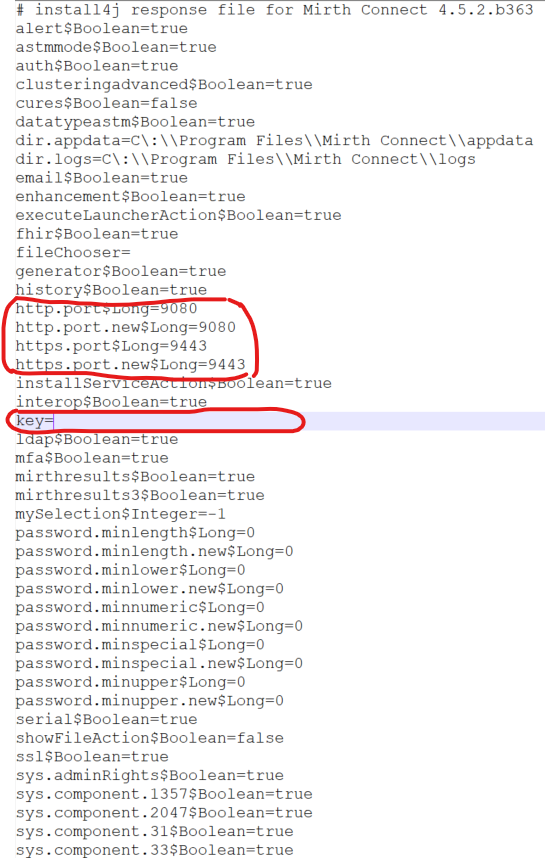 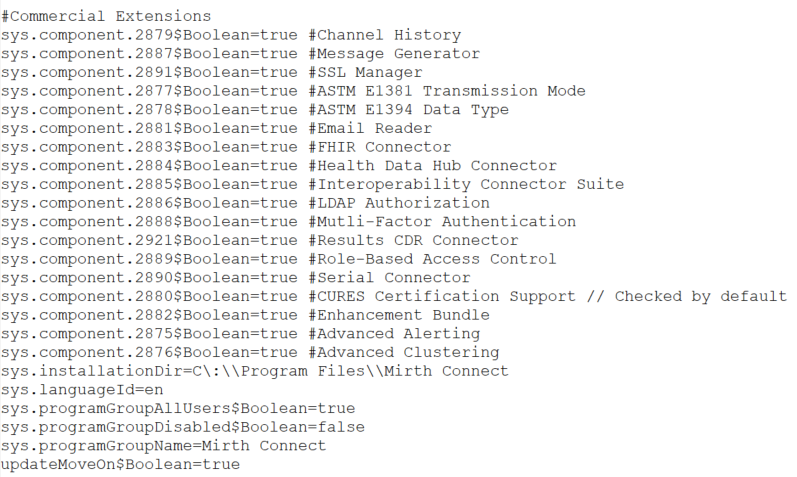

### Get Mirth https/https ports from .env file
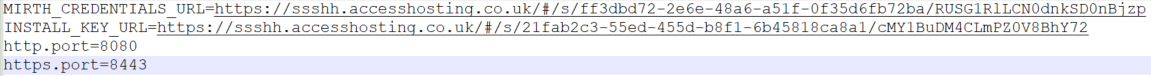

In [ ]:
HttpPort = os.getenv("http.port")
HttpSport = os.getenv("https.port")
key = os.getenv("INSTALL_KEY_URL")
databaseUrl = os.getenv("databaseUrl")

HttpPort, HttpSport, key, databaseUrl

## Using Access Hosting Encrypting portal for Mirth authentication + sharing the License Key

### Function to extract encrupted content from: https://ssshh.accesshosting.co.uk/
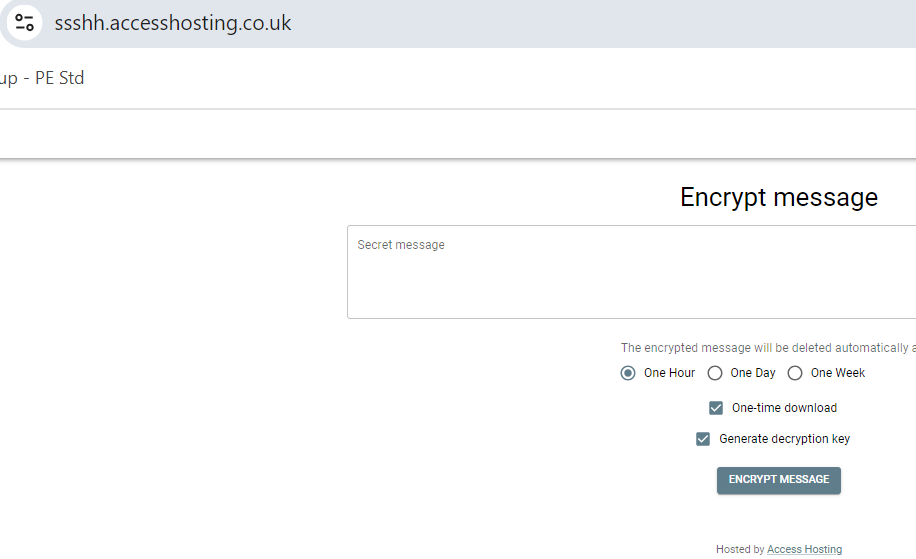


In [3]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

def extract_secret_text(url):
    # Setup Chrome options for headless mode
    chrome_options = Options()
    chrome_options.add_argument("--headless")  # Run in headless mode
    chrome_options.add_argument("--no-sandbox")  # Overcome limited resource problems
    chrome_options.add_argument("--disable-dev-shm-usage")  # Overcome limited resource problems
    chrome_options.add_argument("--disable-gpu")  # Disable GPU hardware acceleration
    chrome_options.add_argument("--window-size=1920x1080")  # Set a specific window size
    chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36")  # Set user-agent
    chrome_options.add_argument("--log-level=3")  # Suppress warnings and errors in logs
    chrome_options.add_argument("--disable-extensions")  # Disable extensions for more lightweight operation
    
    # Start the ChromeDriver in headless mode
    driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=chrome_options)
    
    # Optional: Set implicit wait
    driver.implicitly_wait(10)

    try:
        # Open the URL
        driver.get(url)

        # Wait for the loading message to disappear (prefer WebDriverWait over time.sleep)
        loading_message_xpath = "//h4[contains(text(), 'Fetching from database')]"
        WebDriverWait(driver, 60).until(
            EC.invisibility_of_element_located((By.XPATH, loading_message_xpath))
        )

        # After loading is complete, wait for the specific content to appear
        content_xpath = "//p[@data-test-id='preformatted-text-secret']"  # XPath for the desired element
        secret_text_element = WebDriverWait(driver, 60).until(
            EC.visibility_of_element_located((By.XPATH, content_xpath))
        )

        # Extract the text from the specified element
        secret_text = secret_text_element.text

        return secret_text

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

    finally:
        # Close the browser
        driver.quit()

### Extract Mirth license Key from .env file

In [ ]:
keyUrl = os.getenv("INSTALL_KEY_URL")
print(keyUrl)

extracted_key = extract_secret_text(keyUrl)
if extracted_key:
    print("Key extracted:", extracted_key)
else:
    print("Failed to extract the key.")

del keyUrl

### Update response file content

In [ ]:
Upgrade_dir = os.path.join(os.getcwd() , "DemoUpgrade")
response_file_path = os.path.join(Upgrade_dir, "response.varfile")

try:
    with open(response_file_path, 'r') as file:
        lines = file.readlines()

    # Update lines where http.port$Long and https.port$Long are found
    with open(response_file_path, 'w') as file:
        for line in lines:
            if "http.port$Long=" in line:
                file.write(f"http.port$Long={HttpPort}\n")
            elif "https.port$Long=" in line:
                file.write(f"https.port$Long={HttpSport}\n")
            elif "http.port.new$Long=" in line:
                file.write(f"http.port.new$Long={HttpPort}\n")
            elif "https.port.new$Long=" in line:
                file.write(f"https.port.new$Long={HttpSport}\n")
            elif "key=" in line:
                file.write(f"key={extracted_key}\n")
            else:
                file.write(line)

    print(f"Ports updated successfully: HTTP={HttpPort}, HTTPS={HttpSport}")

except FileNotFoundError:
    print(f"File {response_file_path} not found.")
except Exception as e:
    print(f"An error occurred: {e}")

### Get Mirth Credentials from .env file
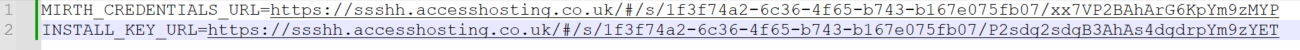

The ".env" file should be located in the same directory as this notebook.

In [6]:
credentialsUrl = os.getenv("MIRTH_CREDENTIALS_URL")

extracted_credentials = extract_secret_text(credentialsUrl)
if extracted_credentials:
    print("Credentials extracted:", extracted_credentials)
else:
    print("Failed to extract the credentials.")

# Splitting the string using '///' as the separator
username = extracted_credentials.split("///")[0]
password = extracted_credentials.split("///")[1]
del credentialsUrl
del extracted_credentials
username, password

Credentials extracted: ThisIsTheLogin///AndHereIsThePassword


('ThisIsTheLogin', 'AndHereIsThePassword')

### Extratct JSESSIONID for Session Management purpose

In [7]:
mirth_host = "https://localhost"
mirth_url = mirth_host + ":" + HttpSport

# Function to get the API session token
def get_session_token(username, password):
    url = f"{mirth_url}/api/users/_login"
    print(url)
    payload = "username=" + username + "&password=" + password
    headers = {"Content-Type": "application/x-www-form-urlencoded",
               "X-Requested-With": "XMLhttpRequest"
               }
    
    response = requests.post(url, headers=headers, data=payload, verify=False) # MUST enable SSL verification // verify='/path/to/ca.crt'
    
    if response.status_code == 200:
        return response.cookies["JSESSIONID"]
    else:
        print(f"Failed to log in: {response.status_code}")
        return None


session_token = get_session_token(username, password)
del username
del password
session_token

https://localhost:8443/api/users/_login


C:\Users\Haitem.ELAaouani\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


'node06spo2jufg0pt149qpd9sb6swd2.node0'

# Get channels state (Deployed/Undeployed?)

In [12]:
cookies = {"JSESSIONID": str(session_token)}  #Cookies for Mirth APIs
headers = {'X-Requested-With': 'XMLHttpRequest', "Content-Type": "application/xml"}  #Headers for Mirth APIs

In [ ]:
# Function to get channel details
def get_channel_statuses():
    url = f"{mirth_url}/api/channels/statuses?includeUndeployed=true"
    response = requests.get(url, headers=headers, cookies=cookies, verify=False) # MUST enable SSL verification // verify='/path/to/ca.crt'
    
    if response.status_code == 200:
        try:
            # Parse the XML response
            root = ET.fromstring(response.content)
            channel_statuses = []
            # Extract only the required fields from each top-level dashboardStatus
            for dashboard_status in root.findall('.//dashboardStatus'):
                # Ensure the element is a top-level dashboardStatus and not inside childStatuses
                parent = dashboard_status.getparent()  # Ensure this element is not inside another node (like childStatuses)
                if parent is not None and parent.tag == "childStatuses":
                    continue  # Skip if inside childStatuses
                
                channelId = dashboard_status.find('channelId')
                name = dashboard_status.find('name')
                state = dashboard_status.find('state')

                if channelId is not None and name is not None and state is not None:
                    status_info = {
                        "channelId": channelId.text,
                        "name": name.text,
                        "state": state.text,
                    }
                    channel_statuses.append(status_info)
                else:
                    print("One of the required fields is missing for a channel. Skipping...")
            
            return channel_statuses
   
        except ET.ParseError:
            print("Failed to parse XML response.")
            return None
    else:
        print(f"Failed to get channel statuses: {response.status_code}")
        return None
    
channels = get_channel_statuses()
channels

df = pd.DataFrame(channels)
df.rename(columns={"name": "ChannelName", "channelId": "ChannelID", "state": "IsDeployed"}, inplace=True)

# Save the DataFrame to a CSV file
csv_file = os.path.join(Upgrade_dir, "mirth_channels.csv")
df.to_csv(csv_file, index=False)

df

# Stop RIO

# Undeploy the channels

In [ ]:
# Function to filter and undeploy the "STARTED" channels
def undeploy_started_channels(df):
    # Filter channels that are currently deployed
    started_channels = df[df["IsDeployed"] == "STARTED"]["ChannelID"].tolist()
    print(started_channels)
    
    if not started_channels:
        print("No channels are currently deployed.")
        return
    
    # Create XML body for the undeploy request
    root = ET.Element("set")
    for channel_id in started_channels:
        string_elem = ET.SubElement(root, "string")
        string_elem.text = channel_id
    
    # Convert XML structure to string
    xml_body = ET.tostring(root, encoding="unicode", method="xml")
    
    # Define API endpoint and headers
    url = f"{mirth_url}/api/channels/_undeploy"
    
    # Send the undeploy request
    response = requests.post(url, headers=headers, cookies=cookies, data=xml_body, verify=False)
    
    if response.status_code in [200, 204]:
        print("Successfully undeployed the channels.")
    else:
        print(f"Failed to undeploy channels: {response.status_code}")

undeploy_started_channels(df)

# Backup Configuration, Channels, Libraries and Logs !/!/!/!/!/!/!/!/!/!/!
The following code would use Python subprocesses to interact with the file system and shell commands:

In [15]:
# Define paths and variables
backup_dir = os.path.join(Upgrade_dir, "BackUp")
vm_options = os.path.join(Upgrade_dir, "VMoptions.txt")
mirth_channels_file = os.path.join(backup_dir, "channels_backup.xml")
mirth_config_file = os.path.join(backup_dir, "config_backup.xml")

mirth_dir = r"C:\Program Files\Mirth Connect"
mirth_config_dir = os.path.join(mirth_dir, "conf")
mirth_libraries_dir = os.path.join(mirth_dir, "custom-lib")
mirth_logs_dir = os.path.join(mirth_dir, "logs")
mirth_properties_file = os.path.join(mirth_config_dir, "mirth.properties")

# Create backup directory if it doesn't exist
if not os.path.exists(backup_dir):
    os.makedirs(backup_dir)

In [16]:
# Step 1.1: Backup Mirth Config Folder
config_folder_backup_path = os.path.join(backup_dir, "configuration_backup")
shutil.copytree(mirth_config_dir, config_folder_backup_path)

# Step 1.2: Backup Mirth Libraries
lib_backup_path = os.path.join(backup_dir, "custom_libraries_backup")
shutil.copytree(mirth_libraries_dir, lib_backup_path)

# Step 1.3: Backup Mirth Logs
logs_backup_path = os.path.join(backup_dir, "logs_backup")
shutil.copytree(mirth_logs_dir, logs_backup_path)

# BackUp mirth_channels_file.xml
mirth_channels = os.path.join(backup_dir, "mirth_channels.xml")
url = f"{mirth_url}/api/channels"

# Send GET request
response = requests.get(url, headers=headers, cookies=cookies, verify=False)  # Set verify='/path/to/mirth_cert.pem' if using SSL

# Check if the request was successful
if response.status_code == 200:
    # Write response content to the output file
    with open(mirth_channels_file, 'wb') as file:
        file.write(response.content)
    print("Channels exported successfully.")
else:
    print(f"Failed to export channels. Status code: {response.status_code}")

# Check if the backup file was created successfully
if os.path.exists(mirth_channels_file):
    print(f"Channels successfully exported to: {mirth_channels_file}")
else:
    print("Failed to export channels. Please check the error messages.")

Channels exported successfully.
Channels successfully exported to: c:\Users\Haitem.ELAaouani\OneDrive - Access UK Ltd\Documents\MirthDev\DemoUpgrade\BackUp\channels_backup.xml


C:\Users\Haitem.ELAaouani\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [19]:
# BackUp mirth_config.xml
mirth_config = os.path.join(backup_dir, "mirth_config.xml")
url = f"{mirth_url}/api/server/configuration"
print(url)

# Send GET request
response = requests.get(url, headers=headers, cookies=cookies, verify=False)  # Set verify='/path/to/mirth_cert.pem' if using SSL

# Check if the request was successful
if response.status_code == 200:
    # Write response content to the output file
    with open(mirth_config, 'wb') as file:
        file.write(response.content)
    print("Configuration exported successfully.")
else:
    print(f"Failed to export the configuration. Status code: {response.status_code}")

# Check if the backup file was created successfully
if os.path.exists(mirth_config):
    print(f"Channels successfully exported to: {mirth_config}")
else:
    print("Failed to export channels. Please check the error messages.")

https://localhost:8443/api/server/configuration
Configuration exported successfully.
Channels successfully exported to: c:\Users\Haitem.ELAaouani\OneDrive - Access UK Ltd\Documents\MirthDev\DemoUpgrade\BackUp\mirth_config.xml


C:\Users\Haitem.ELAaouani\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


# Stop the Mirth Service

In [17]:
MirthServices = ["Mirth Connect Service"]
for MirthService in MirthServices:
    subprocess.run(["net", "stop", MirthService], capture_output=True, text=True)

# Install Mirth

In [ ]:
# Define the installers directory
installers_dir = os.path.join(Upgrade_dir, "Installers")

# Initialize variables to store the installer paths
mirth_installer = None
java_installer = None
response_file = None
mirth_launcher_installer = None

# List all files in the installers directory
for filename in os.listdir(installers_dir):
    # Check for Mirth installer (assuming the filename contains 'mirthconnect' and ends with '.exe')
    if re.search(r'mirthconnect.*\.exe$', filename, re.IGNORECASE):
        mirth_installer = os.path.join(installers_dir, filename)

    # Check for Mirth administrator launcher (assuming the filename contains 'mirth-administrator-launcher' and ends with '.exe')
    elif re.search(r'mirth-administrator-launcher.*\.exe$', filename, re.IGNORECASE):
        mirth_launcher_installer = os.path.join(installers_dir, filename)
    
    # Check for Amazon Corretto installer (assuming the filename contains 'amazon-corretto' and ends with '.msi')
    elif re.search(r'amazon-corretto.*\.msi$', filename, re.IGNORECASE):
        java_installer = os.path.join(installers_dir, filename)
    
    # Check for Mirth response file (assuming it ends with '.varfile')
    elif filename.endswith('.varfile'):
        response_file = os.path.join(installers_dir, filename)

# Output the results
print(f"Mirth Installer: {mirth_installer}")
print(f"Mirth Installer: {mirth_launcher_installer}")
print(f"Java Installer: {java_installer}")
print(f"Response File: {response_file}")

In [ ]:
# Install Java Corretto in silent mode
java_install_cmd = ["msiexec", "/i", java_installer, "/qn", "/norestart"] # "/qn": Quiet mode with no UI /// "/norestart": Prevent automatic restart

Java_Installed = None
print("-*-*-*-*-*-*-*Installing Java...-*-*-*-*-*-*-*")
try:
    result = subprocess.run(java_install_cmd, capture_output=True, text=True, check=True)
    Java_Installed = True
    print("Java Corretto installation completed successfully.")
except subprocess.CalledProcessError as e:
    print(f"Error during Java Corretto installation: {e}")
    print(f"Error output: {e.stderr}")

# Install Mirth Connect
print("-*-*-*-*-*-*-*Installing Mirth Connect...-*-*-*-*-*-*-*")
Mirth_installed = None
if Java_Installed:
    # Initialize result_install to None
    result_install = None

    try:
        mirth_install_cmd = [mirth_installer, "-q", "-varfile", response_file, "-overwrite", "-noFailures"] # -q Quiet mode

        result_install = subprocess.run(mirth_install_cmd, capture_output=True, text=True, check=True)
        Mirth_installed = True
        print("Mirth Connect installation completed.")
    except subprocess.CalledProcessError as e:
        print(f"Failed to install Mirth Connect: {e}")
        print(f"Standard Output:\n{e.stdout}")
        print(f"Standard Error:\n{e.stderr}")

        # Log the exact command used
        #print(f"Command Used:\n{' '.join(mirth_install_cmd)}")

        # Check if the installer generated a log file in the current directory
        log_file = os.path.join(installers_dir, "mirthconnect_install.log")
        if os.path.exists(log_file):
            with open(log_file, 'r') as f:
                print(f"Contents of Mirth installer log:\n{f.read()}")
        else:
            print("No installer log found in the expected location.")

    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Install Mirth Connect Launcher
print("-*-*-*-*-*-*-*Installing Mirth Launcher...-*-*-*-*-*-*-*")
if Java_Installed and Mirth_installed:
    # Initialize result_install to None
    result_install = None

    try:
        print("Installing Mirth Connect Launcher...")
        mirthLauncher_install_cmd = [mirth_launcher_installer, "-q",  # Quiet mode
                                    "-overwrite", "-noFailures"]

        result_install = subprocess.run(mirthLauncher_install_cmd, capture_output=True, text=True, check=True)
        print("Mirth Connect Launcher installation completed.")
        print("Standard Output:\n", result_install.stdout)
        print("Standard Error:\n", result_install.stderr)
    except subprocess.CalledProcessError as e:
        print(f"Failed to install Mirth Connect Launcher: {e}")
        print(f"Standard Output:\n{e.stdout}")
        print(f"Standard Error:\n{e.stderr}")

        # Log the exact command used
        #print(f"Command Used:\n{' '.join(mirthLauncher_install_cmd)}")

        # Check if the installer generated a log file in the current directory
        log_file = os.path.join(installers_dir, "mirthconnectLauncher_install.log")
        if os.path.exists(log_file):
            with open(log_file, 'r') as f:
                print(f"Contents of Mirth Launcher installer log:\n{f.read()}")
        else:
            print("No installer log found in the expected location.")

    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Include a Step to set in the properties file

#### Key

#### ports
 


 
### Update TLS AND configurationmap

In [ ]:
import re

mirth_properties_path = r'C:\Program Files\Mirth Connect\conf\mirthDemo.properties'
required_ciphers = ['TLS_EMPTY_RENEGOTIATION_INFO_SCSV', 'TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA']

def update_mirth_properties():
    # Read the file contents
    with open(mirth_properties_path, 'r') as file:
        config_data = file.read()

    # Modify https.ciphersuites to include required ciphers if they are missing
    cipher_match = re.search(r'^https\.ciphersuites\s*=\s*(.*)', config_data, re.MULTILINE)

    if cipher_match:
        # Extract the current cipher suites
        ciphersuites = cipher_match.group(1).split(',')
        
        # Add missing cipher suites
        for cipher in required_ciphers:
            if cipher not in ciphersuites:
                ciphersuites.append(cipher)

        # Rebuild the ciphersuites string
        updated_ciphersuites = ','.join(ciphersuites)

        # Replace the old ciphersuite line with the updated one
        config_data = re.sub(
            r'^https\.ciphersuites\s*=.*$', 
            f'https.ciphersuites = {updated_ciphersuites}', 
            config_data, 
            flags=re.MULTILINE
        )

    # Modify configurationmap.path and add configurationmap.location = database
    config_data = re.sub(
        r'^configurationmap\.path\s*=.*$', 
        'configurationmap.location = database\nconfigurationmap.path =', 
        config_data, 
        flags=re.MULTILINE
    )

    # Replace database = derby with database = sqlserver
    config_data = re.sub(
        r'^database\s*=\s*derby$', 
        'database = sqlserver', 
        config_data, 
        flags=re.MULTILINE
    )

    # Replace the database.url line and add #SQLServer comment above
    config_data = re.sub(
        r'^database\.url\s*=.*$', 
        '\n#SQLServer\ndatabase.url = ' + databaseUrl, 
        config_data, 
        flags=re.MULTILINE
    )

    # Write the updated configuration back to the file
    with open(mirth_properties_path, 'w') as file:
        file.write(config_data)
    
    print("Ciphersuites, configurationmap, database, and database.url updated successfully.")

# Call the function to modify the ciphersuites and configuration
update_mirth_properties()

# Service / Server VM Options update

In [ ]:
# Define paths
#source_file = 'C:\Users\Haitem.ELAaouani\OneDrive - Access UK Ltd\Documents\MirthDev\DemoUpgrade'  # This is the source file in the current directory
destination_path = r'C:\Program Files\Mirth Connect'
files_to_update = ['mcservice.vmoptions', 'mcserver.vmoptions']

# Read content of the source file
try:
    with open(vm_options, 'r') as src:
        content_to_append = "\n" + src.read()

    for file_name in files_to_update:
        destination_file = os.path.join(destination_path, file_name)
        
        # Check if the destination file exists
        if os.path.exists(destination_file):
            with open(destination_file, 'a') as dest:
                dest.write(content_to_append)
            print(f"Content appended to {file_name}")
        else:
            print(f"File {file_name} not found in {destination_path}")

except Exception as e:
    print(f"Error: {e}")

# Restore the Libraries

In [ ]:
# Copy the previous configuration and libraries to the new Mirth installation
new_mirth_dir = "C:\Program Files\Mirth Connect"
new_mirth_libraries_dir = os.path.join(new_mirth_dir, "custom-lib")

# Copy old libraries to the new version
shutil.copytree(lib_backup_path, new_mirth_libraries_dir, dirs_exist_ok=True)

#new_mirth_config_dir = os.path.join(new_mirth_dir, "conf")
# Copy old configuration to the new version
#shutil.copytree(config_backup_path, new_mirth_config_dir, dirs_exist_ok=True)


# Import Configuration Files, Channels

In [ ]:
# Import Channels using Mirth REST API
#import_channels_cmd = [
#    "curl", "-u", "admin:admin", "-H", "Content-Type: application/xml",
#    "-X", "POST", "http://localhost:8080/api/channels",
#    "--data-binary", f"@{mirth_channels_file}"
#]
#subprocess.run(import_channels_cmd)


url = f"{mirth_url}/api/channels"

# Read the XML file content
try:
    with open(mirth_channels_file, 'rb') as file_data:
        # Send POST request with basic authentication and XML content
        response = requests.post(url, headers=headers, cookies=cookies, data=file_data, verify=False)

    # Check if the request was successful
    if response.status_code == 200:
        print("Channels imported successfully.")
    else:
        print(f"Failed to import channels. Status code: {response.status_code}")
        print(f"Response: {response.text}")

except FileNotFoundError:
    print(f"File {mirth_channels_file} not found.")
except Exception as e:
    print(f"An error occurred: {e}")

# Start the New Mirth Service


In [ ]:
import subprocess

mirth_service_name = "Mirth Connect Service"

try:
    print(f"Starting {mirth_service_name}...")
    
    # Start the service using subprocess.run
    result = subprocess.run(f'net start "{mirth_service_name}"', shell=True, capture_output=True, text=True)

    # Check the return code
    if result.returncode == 0:
        print(f"{mirth_service_name} started successfully.")
    else:
        print(f"Failed to start {mirth_service_name}.")
        print(f"Standard Output:\n{result.stdout}")
        print(f"Standard Error:\n{result.stderr}")
        
except Exception as e:
    print(f"An error occurred: {e}")